#  "Thresholding"

# Recap

This is the Lab on Thresholding for Classical Image Segmention in CE6003.  You should complete the tasks in this lab as part of the Thresholding section of the lesson.

Please remember this lab must be completed before taking the quiz at the end of this lesson.


First, if we haven't already done so, we need to clone the various images and resources needed to run these labs into our workspace.

In [2]:
!git clone https://github.com/EmdaloTechnologies/CE6003.git

Cloning into 'CE6003'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 90 (delta 3), reused 8 (delta 3), pack-reused 80
Unpacking objects: 100% (90/90), done.


# Introduction

In this lab we introduce our first image segmentation project where we will use thresholding operations to segment a relatively simple image. We will work through this project using the types of image processing techniques such projects typically need and then segment an image.  

At the end of the lab we'll review the work we've done and assess what types of images and projects this approach is effective for.


# Goal

In this tutorial we will learn about three key items:
* The general image processing algorithms that are required for most image processing projects; e.g. denoising, 
* Using our first classical segmentation technique on images (thresholding);
* How to use Otsu's Method to automatically find a suitable threshold level to segment an image.


# Background

Image segmentation is the process of partitioning a digital image into multiple segments to make the image easier to analyze.  Often we are looking to locate objects and boundaries in the original image.  

A more precise way of looking at it is to say that image segmentation's goal is to assign a label to every pixel in an image such that pixels with the same label share certain characteristics.  

For example, these images show a typical road scene on the left and a segmented version of the image on the right where the cars have been separated from the road, the buildings, the people in the scene, etc.

<p float="center">
  <img src="https://github.com/EmdaloTechnologies/CE6003/blob/master/images/lab2/bg-road.png?raw=1" width="450" />
</p>


# Our First Segmenter

So, now that we've seen what is possible, let's start by solving our first segmentation problem.

Let's look at this image of a starfish.  Let's examine it in its original color, in grayscale and in black and white.

Colour                            |  Grayscale                           |  Black & White
:--------------------------------:|:------------------------------------:|:---------------------------:
![](https://github.com/EmdaloTechnologies/CE6003/blob/master/images/lab2/starfish_resize.png?raw=1)   | ![](https://github.com/EmdaloTechnologies/CE6003/blob/master/images/lab2/starfish_grey_resize.png?raw=1) | ![](https://github.com/EmdaloTechnologies/CE6003/blob/master/images/lab2/starfish_bw_resize.png?raw=1)

We are searching these images for clues as to how we might be able to segment them into two regions - the 'starfish' region and the 'not starfish' region.

It turns out we can segment this image into a region approximating the starfish and a background region (the 'not starfish; region) using thresholding, along with general purpose image processing techniques such as denoising, morphological operations, and some contour detection and drawing.  Finally, once we've established a boundary for the starfish, we can fill our starfish shape. After that we'll use some bitwise operations to overlay our segmented image over the original image.

First, lets use OpenCV's fastN1MeansDenoisingColored routine to denoise the image.  We're using a larger 'h' and 'hColor' value than typically used as the image is more noisy than images typically used with these technique.  (This should make more sense as we go forward into the CNN segmentation examples).

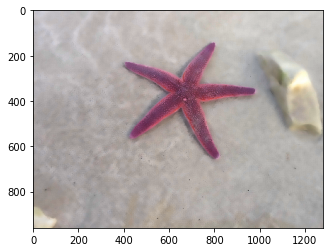

In [3]:
# First import OpenCV, NumPY and MatPlotLib as we will use these libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
#import cv2 as cv

%matplotlib inline

# Load a color image
img = cv2.imread("/content/CE6003/images/lab2/starfish.png")

# Apply some blurring to reduce noise

# h is the Parameter regulating filter strength for luminance component. 
# Bigger h value perfectly removes noise but also removes image details, 
# smaller h value preserves details but also preserves some noise

# Hint: I recommend using larger h and hColor values than typical to remove noise at the
# expense of losing image details

# YOUR CODE HERE
#dst = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)
# Experiment with setting h and hColor to a suitable value.
# Exercise: Insert code here to set values for h and hColor. 
h = 20
hColor = 10
# END YOUR CODE HERE

# Default values
templateWindowSize = 7
searchWindowSize = 21
    
blur = cv2.fastNlMeansDenoisingColored(img, None, h, hColor,templateWindowSize,searchWindowSize)
    
plt.imshow(cv2.cvtColor(blur, cv2.COLOR_BGR2RGB))


After applying the fastN1MeansDenoisingColored routine above, you should end up with an image similar to the one on the right here.  You may need to vary the h and hColor parameters to observe the effect of changing them on the blurred image.

Your blurred image should look like this one.

<img src="https://github.com/EmdaloTechnologies/CE6003/blob/master/images/lab2/starfish_blur.png?raw=1" alt="Blurred Starfish" align="left" style="width: 300px;"/>


Now, lets run a morphological operation on the blurred image.  

For this example, we are going to generate a gradient.  

This builds on dilation and erosion.  You can read more about erosion and dilation 
in the 'Basics' section of Lesson 2.

Today we are going to use them to generate an outline for our starfish.


# Edge Detection
Instead of using a gradient, you could use an edge detection such as Sobol, Laplacian and Canny here in combination with adjusting the image denoising step above.  I'll leave those as an exercise for the reader for now!

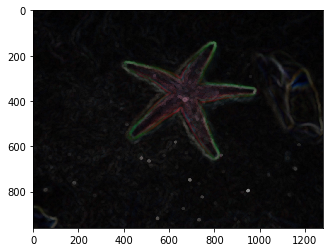

In [4]:
# Apply a morphological gradient (dilate the image, erode the image, and take the difference

elKernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (13,13))

# YOUR CODE HERE
# Exercise: Use openCV's morphologyEx to generate a gradient using the kernel above
gradient = cv2.morphologyEx(blur, cv2.MORPH_GRADIENT, elKernel)
# END YOUR CODE HERE

plt.imshow(cv2.cvtColor(gradient, cv2.COLOR_BGR2RGB))

After applying the gradient morphology routine above, you should end up with an image similar to the one shown here.  The outline of the starfish should be starting to emerge at this point.
    
<img src="https://github.com/EmdaloTechnologies/CE6003/blob/master/images/lab2/starfish_grad.png?raw=1" alt="Gradient Starfish" align="left" style="width: 300px;"/>



We now have completed the pre-processing of our image. 

From this point onwards, we are concerning ourselves with:

a) filling the region of interest, and

b) removing artefacts from the image which we are not interested in.

There are quite a few approaches we can take to this (including not doing them at all), but today lets apply OTSU's threshold to convert the image to black and white, and perform a closing operation to 'fill in' the starfish and then perform some erosion to remove parts of the image that we consider noise.

## OTSU Thresholding
When converting from a grayscale image to a black and white image, selecting a good threshold value can be a time-consuming and manual process.  There are a number of automatic thresholding techniques available - and Otsu's method thresholding is one of the better known techniques.

Conceptually simple, and relatively low cost computationally, Otsu's threshold iterate through all the possible threshold values to find the threshold value where the sum of foreground and background spreads is at its minimum. 


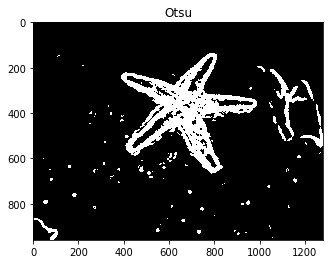

In [12]:
# Apply Otsu's method - or you can adjust the level at which thresholding occurs
# and see what the effect of this is

# Convert gradient to grayscale
gradient2 = cv2.cvtColor(gradient, cv2.COLOR_BGR2GRAY)


# YOUR CODE HERE
# Exercise: Generate a matrix called otsu using OpenCV's threshold() function.  Use
# Otsu's method.
ret, otsu = cv2.threshold(gradient2,127,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(otsu, cmap='gray')
plt.title('Otsu')

# END YOUR CODE HERE

       
# Apply a closing operation - we're using a large kernel here. By all means adjust the size of this kernel
# and observe the effects
closingKernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (33,33))
close = cv2.morphologyEx(otsu, cv2.MORPH_CLOSE, closingKernel)
    

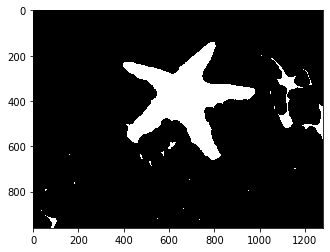

In [13]:
# Erode smaller artefacts out of the image - play with iterations to see how it works
    
# YOUR CODE HERE
# Exercise: Generate a matrix called eroded using cv2.erode() function over the 'close' matrix.
# Experiment until your output image is similar to the image below
eroded = cv2.erode(close,elKernel,iterations = 1)
# END YOUR CODE HERE

plt.imshow(eroded, cmap='gray')

After switching to black and white and applying our closing and erosion operations, our simplified starfish is starting to emerge
    
Original Image            | B&W Image                      | After Closing                   | After Erosion
:------------------------:|:------------------------------:|:-------------------------------:|:--------------
![](https://github.com/EmdaloTechnologies/CE6003/blob/master/images/lab2/starfish.png?raw=1)  | ![](https://github.com/EmdaloTechnologies/CE6003/blob/master/images/lab2/starfish_otsu.png?raw=1)  | ![](https://github.com/EmdaloTechnologies/CE6003/blob/master/images/lab2/starfish_closed.png?raw=1) | ![](https://github.com/EmdaloTechnologies/CE6003/blob/master/images/lab2/starfish_eroded.png?raw=1)


So, now we've effectively segmented our image. 

Now, let's post-process the image to find the contours that represent the edge of the starfish.  We'll just use the intuition that the starfish is the largest object in the scene.

Then we'lll do a little image manipulation to generate a colour representing the starfish, another colour representing the background (i.e. not the starfish) and then merge those colours with the original image.

You'll notice the closing and erosion steps are not perfect - they're not supposed to be.  They are good enough to feed into the findContours routine.  By all means, tune them further to get better quality input into findContours.

In the findContours routine we're using cv2.RETR_EXTERNAL.  This is to reduce the complexity of post-processing by only reporting 'external' contours (i.e. we'll attempt to suppress contours that are inside other contours).

In [0]:
p = int(img.shape[1] * 0.05)
eroded[:, 0:p] = 0
eroded[:, img.shape[1] - p:] = 0


In [0]:
# YOUR CODE HERE
# Exercise: Find the contours - just external contours to keep post-processing simple
image, contours, hierarchy =  cv2.findContours(eroded, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

# END YOUR CODE HERE

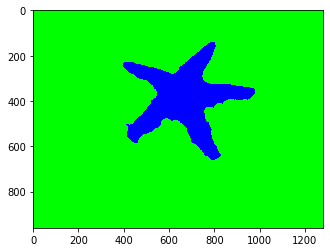

In [18]:


# Sort the candidates by size, and just keep the largest one
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:1]

# Lets create two images, initially all zeros (i.e. black)
# One image will be filled with 'Blue' wherever we think there's some starfish
# The other image will be filled with 'Green' whereever we think there's not some starfish
h, w, num_c = img.shape
segmask = np.zeros((h, w, num_c), np.uint8)
stencil = np.zeros((h, w, num_c), np.uint8)

# I know we've only one contour, but - in general - we'd expect to have more contours to deal with
for c in contours:
    # Fill in the starfish shape into segmask
    cv2.drawContours(segmask, [c], 0, (255, 0, 0), -1)
    # Lets fill in the starfish shape into stencil as well
    # and then re-arrange the colors using numpy
    cv2.drawContours(stencil, [c], 0, (255, 0, 0), -1)
    stencil[np.where((stencil==[0,0,0]).all(axis=2))] = [0, 255, 0]
    stencil[np.where((stencil==[255,0,0]).all(axis=2))] = [0, 0, 0]

# Now, lets create a mask image by bitwise ORring segmask and stencil together
mask = cv2.bitwise_or(stencil, segmask)

plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))

You should have generated a reasonable mask representing our image as having two parts - a 'starfish' and 'not a starfish'.  It should look like the final mask in the image below.
    
Starfish Mask                    | Not Starfish Mask                | Final Mask
:-------------------------------:|:--------------------------------:|:-------------------------------
![](https://github.com/EmdaloTechnologies/CE6003/blob/master/images/lab2/starfish_segmask.png?raw=1) | ![](https://github.com/EmdaloTechnologies/CE6003/blob/master/images/lab2/starfish_stencil.png?raw=1) | ![](https://github.com/EmdaloTechnologies/CE6003/blob/master/images/lab2/starfish_mask.png?raw=1)


In [0]:
# Now, lets just blend our original image with our mask

# YOUR CODE HERE
# Exercise: Blend the original image 'img' and our mask 'mask'
# in any way you see fit, and store it in a variable called output
# Hint: You'll find answers at the bottom of the lab. 
output = cv2.bitwise_or(mask, img)
# END YOUR CODE HERE

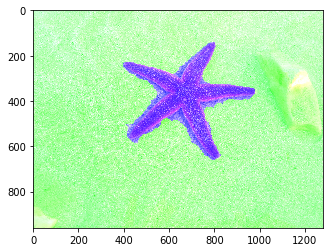

In [20]:
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))

After you blend the original image with your mask you should see an image similar to the image shown here.

<img src="https://github.com/EmdaloTechnologies/CE6003/blob/master/images/lab2/starfish_segmented.png?raw=1" alt="Segmented Starfish" align="left" style="width: 300px;"/>



# Conclusion

So, that completes the first of the four labs to this module.  

To summarise , we''ve learned some basic image processing techniques, such as morphological operations like erosion and dilation, contour detection and we've used these techniques in combination with Otsu's thresholding method to segment an image.
